In [ ]:
import segmentation_models_pytorch as smp
import torch
import torchvision
from einops import rearrange
from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms
from tqdm.auto import tqdm

Load the datasets

In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

In [ ]:
train_dataset = torchvision.datasets.MNIST(r"/raid/arjun/MNIST/", train=True, transform=transforms)
train_dataset


Dataset MNIST
    Number of datapoints: 60000
    Root location: /raid/arjun/MNIST/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
val_dataset = torchvision.datasets.MNIST(r"/raid/arjun/MNIST/", train=False, transform=transforms)
val_dataset


Dataset MNIST
    Number of datapoints: 10000
    Root location: /raid/arjun/MNIST/
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
dataset = train_dataset + val_dataset
dataset, len(dataset)

(<torch.utils.data.dataset.ConcatDataset object at 0x7ff090594130>, 70000)

Visualize the dataset

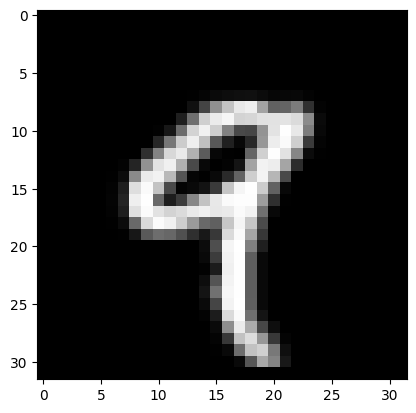

9

In [ ]:
img, gt = dataset[4]

plt.imshow(rearrange(img, "c h w -> h w c"), cmap="gray")
plt.show()
gt

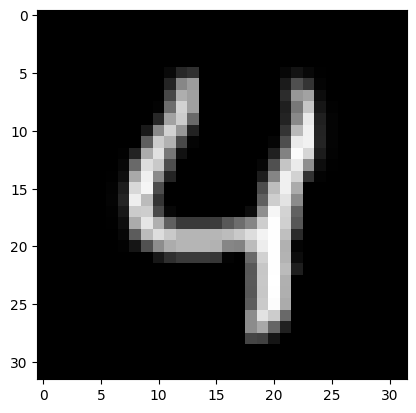

4

In [ ]:
img, gt = dataset[60004]

plt.imshow(rearrange(img, "c h w -> h w c"), cmap="gray")
plt.show()
gt

Gaussian noise

In [ ]:
class NoiseScheduler(nn.Module):
    def __init__(self, betas):
        super().__init__()

        self.betas = betas
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

    def add_noise(self, x0_batch, t):
        standard_noise = torch.randn(x0_batch.shape, device=x0_batch.device)

        sqrt_alphas_cumprod = self.sqrt_alphas_cumprod.to(x0_batch.device)
        sqrt_one_minus_alphas_cumprod = self.sqrt_one_minus_alphas_cumprod.to(x0_batch.device)

        momentum_term = rearrange(sqrt_alphas_cumprod[t], 'n -> n 1 1 1') * x0_batch
        noise_term = rearrange(sqrt_one_minus_alphas_cumprod[t], 'n -> n 1 1 1') * standard_noise

        return momentum_term + noise_term, standard_noise

    def remove_noise(self, xt_batch, pred_batch, t):  # pred_batch is the noise prediction, not the denoised image
        x0_batch = (xt_batch - (self.sqrt_one_minus_alphas_cumprod[t] * pred_batch)) / self.sqrt_alphas_cumprod[t]
        x0_batch = x0_batch.clamp(-1.0, 1.0)

        mean_batch = xt_batch - ((self.betas[t] * pred_batch) / (self.sqrt_one_minus_alphas_cumprod[t])) / torch.sqrt(
            self.alphas[t]
        )

        variance_batch = self.betas[t] * (1.0 - self.alphas_cumprod[t - 1]) / (1.0 - self.alphas_cumprod[t])
        sigma_batch = torch.sqrt(variance_batch)
        standard_noise = torch.randn(xt_batch.shape, device=xt_batch.device)

        # Return only mean when t = 0
        sigma_batch[t == 0] = 0

        return x0_batch, mean_batch + sigma_batch * standard_noise

Visualize some outputs

t = tensor([0], dtype=torch.int32)
beta = tensor([1.0000e-04])


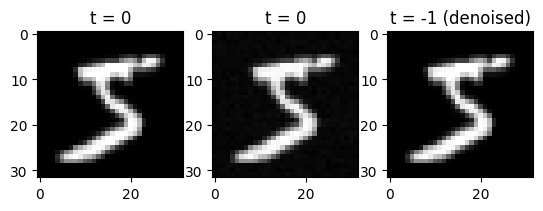


t = tensor([20], dtype=torch.int32)
beta = tensor([0.0021])


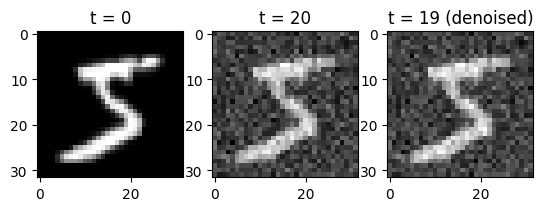


t = tensor([40], dtype=torch.int32)
beta = tensor([0.0041])


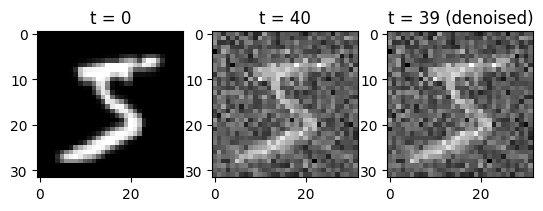


t = tensor([60], dtype=torch.int32)
beta = tensor([0.0061])


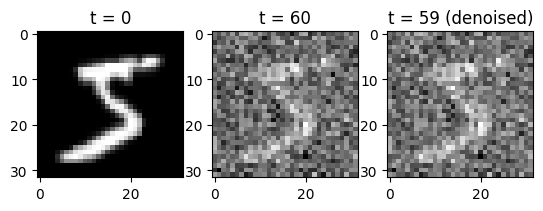


t = tensor([80], dtype=torch.int32)
beta = tensor([0.0081])


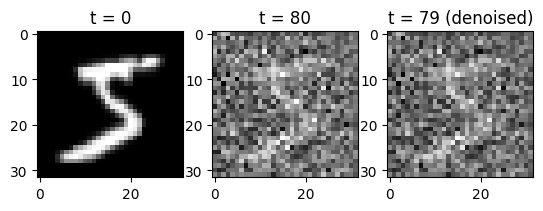


t = tensor([100], dtype=torch.int32)
beta = tensor([0.0100])


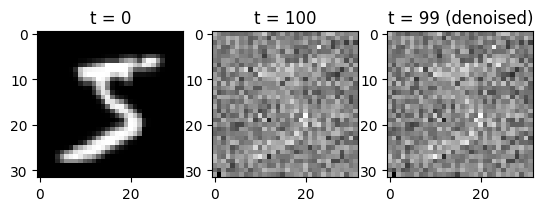


t = tensor([120], dtype=torch.int32)
beta = tensor([0.0120])


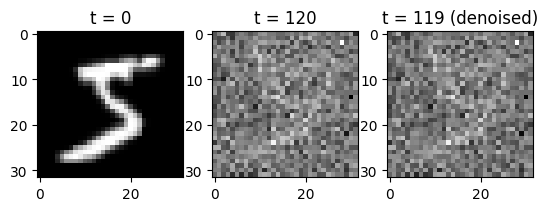


t = tensor([140], dtype=torch.int32)
beta = tensor([0.0140])


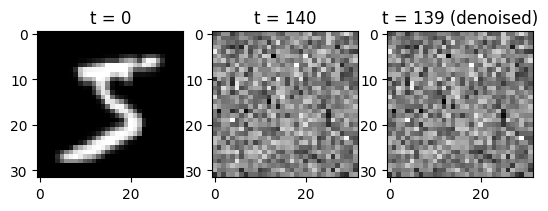


t = tensor([160], dtype=torch.int32)
beta = tensor([0.0160])


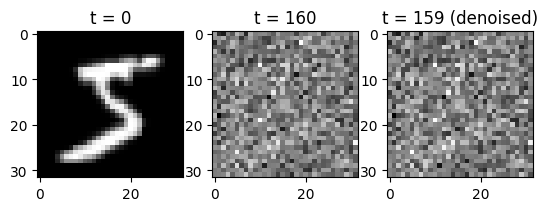


t = tensor([180], dtype=torch.int32)
beta = tensor([0.0180])


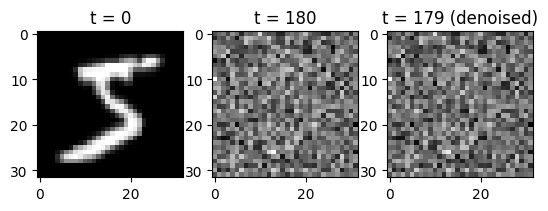


t = tensor([200], dtype=torch.int32)
beta = tensor([0.0200])


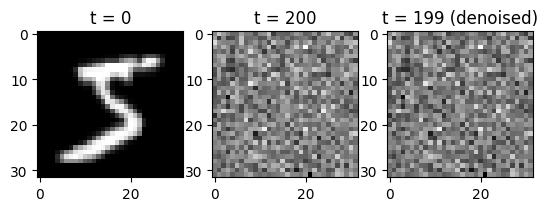

In [ ]:
T = 200
num_timesteps = 11
timesteps = torch.linspace(0, T, num_timesteps)
betas = torch.linspace(0.0001, 0.02, T + 1)

x0, gt = dataset[0]
x0.unsqueeze_(0)
scheduler = NoiseScheduler(betas)

for i in range(num_timesteps):
    t = timesteps[i:i+1].int()
    beta = betas[t]

    xt, noise = scheduler.add_noise(x0, t)

    x0_bar, xt_minus_1 = scheduler.remove_noise(xt, noise, t)

    fig, ax = plt.subplots(1, 3)

    print(f"t = {t}")
    print(f"beta = {beta}")
    # print(f'denoising mean = {mean}')

    ax[0].imshow(rearrange(x0, "1 c h w -> h w c"), cmap="gray")
    ax[0].set_title("t = 0")
    ax[1].imshow(rearrange(xt, "1 c h w -> h w c"), cmap="gray")
    ax[1].set_title(f"t = {int(t)}")
    ax[2].imshow(rearrange(xt_minus_1, "1 c h w -> h w c"), cmap="gray")
    ax[2].set_title(f"t = {int(t - 1)} (denoised)")
    plt.show()

    print()

Train model

In [ ]:
class SimpleArchitecture(nn.Module):
    # Does not perform any time embedding

    def __init__(self):
        super().__init__()

        self.model = smp.Unet(
            encoder_name="resnet18",
            in_channels=1,
            classes=1,
            # encoder_depth=3,
            # decoder_channels=(64, 32, 16),
            # activation="tanh",
        )

    def forward(self, xt):
        return self.model(xt)

In [ ]:
device = torch.device("cuda:0")

In [ ]:
model = SimpleArchitecture()
model.to(device)
sum([parameter.numel() for parameter in model.parameters()])

14321937

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

In [ ]:
T = 200
betas = torch.linspace(0.0001, 0.02, T + 1)
noise_scheduler = NoiseScheduler(betas)
noise_scheduler.to(device)

NoiseScheduler()

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=15000, shuffle=True, pin_memory=True)
len(dataloader)

5

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/5 [00:00<?, ?it/s]

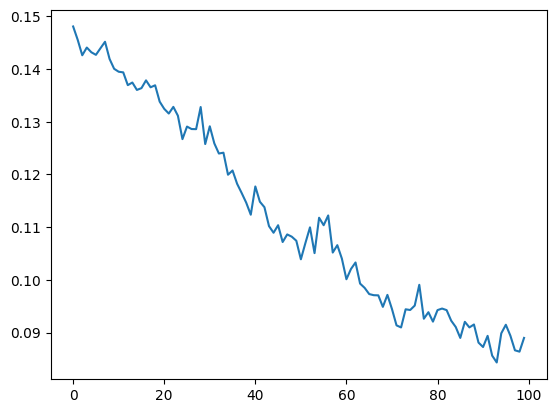

In [ ]:
num_epochs = 100
model.train()

losses = []
for _ in tqdm(range(num_epochs), "Epoch"):
    for batch in tqdm(dataloader, 'Batch', leave=False):
        x0, gts = batch
        x0 = x0.to(device)
        x0 = x0 * 2 - 1  # rescale to be between -1 and 1

        t = torch.randint(0, T, (x0.shape[0],), device=device)

        xt, noise_gt = noise_scheduler.add_noise(x0, t)

        optimizer.zero_grad()
        noise_pred = model(xt)

        loss = criterion(noise_pred, noise_gt)
        loss.backward()
        optimizer.step()

    losses.append(loss.detach().cpu())

plt.plot(losses)
plt.show()

Generate images

t = 280


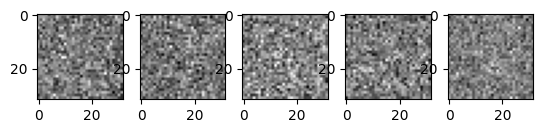

t = 240


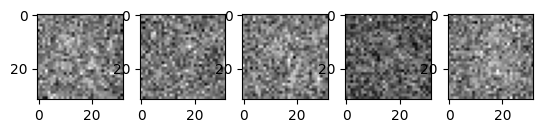

t = 200


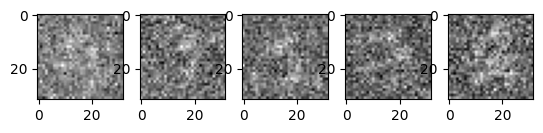

t = 160


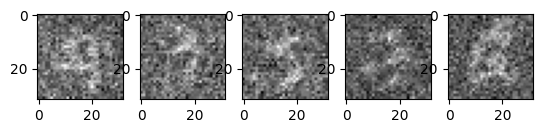

t = 120


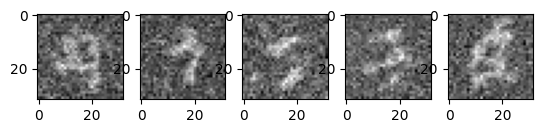

t = 80


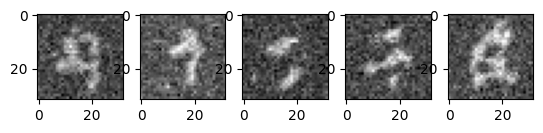

t = 40


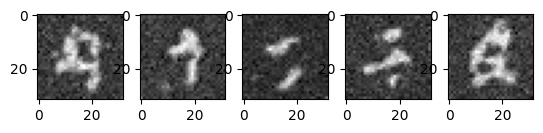

t = 0


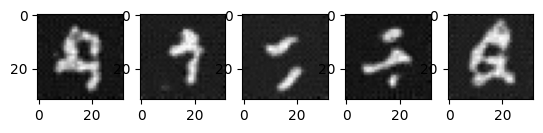

In [24]:
model.eval()

xt = torch.randn((5, 1, 32, 32), device=device)

for t in reversed(range(T)):
    pred = model(xt)

    x0_bar, xt_minus_1 = noise_scheduler.remove_noise(xt, pred, t)
    xt = xt_minus_1  # This will be the new xt

    x0_bar = x0_bar.detach().cpu()
    xt_minus_1 = xt_minus_1.detach().cpu()

    if t % 40 == 0:
        print(f't = {t}')
        fig, ax = plt.subplots(1, xt.shape[0])
        for i in range(xt.shape[0]):
            ax[i].imshow(rearrange(xt_minus_1[i], 'c h w -> h w c'), cmap='gray')
        plt.show()